In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import numpy as np

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
en_songs = pd.read_csv('data/en_songs.csv')
en_songs.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,trees singing wind sky blue angels smiled saw ...,28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
1,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,na yeah spyderman freeze full effect uh huh re...,0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
2,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,really stay baby cold outside got go away baby...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
3,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,get business keep turning witness criminal fee...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en
4,00f9VGHfQhAHMCQ2bSjg3D,Soldier,James TW,hold breath look keep trying darling okay scar...,70,3GNzXsFbzdwM0WKCZtgeNP,Chapters,2019-04-26,urban contemporary,4WiB26kw0INKwbzfb5M6Tv,...,-6.157,1,0.0550,0.28000,0.00000,0.0975,0.305,147.764,224720,en


In [4]:
en_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15405 entries, 0 to 15404
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  15405 non-null  object 
 1   track_name                15405 non-null  object 
 2   track_artist              15405 non-null  object 
 3   lyrics                    15405 non-null  object 
 4   track_popularity          15405 non-null  int64  
 5   track_album_id            15405 non-null  object 
 6   track_album_name          15405 non-null  object 
 7   track_album_release_date  15405 non-null  object 
 8   playlist_name             15405 non-null  object 
 9   playlist_id               15405 non-null  object 
 10  playlist_genre            15405 non-null  object 
 11  playlist_subgenre         15405 non-null  object 
 12  danceability              15405 non-null  float64
 13  energy                    15405 non-null  float64
 14  key   

## Observation

We will choose these features that will be clustered after NLP clustering since they numerical metrics for musical elements :
 - danceability
 - energy
 - speechiness
 - acousticness
 - duration_ms
 - tempo
 - instrumentalness

In [5]:
df = en_songs.loc[:, en_songs.columns.intersection(['danceability','energy', 'speechiness', 'acousticness', 'duration_ms', 'tempo', 'instrumentalness'])]
df


,danceability,energy,speechiness,acousticness,instrumentalness,tempo,duration_ms
0,0.303,0.880,0.0442,0.01170,0.009940,135.225,373512
1,0.845,0.652,0.2160,0.00432,0.007230,111.904,262467
2,0.425,0.378,0.0341,0.68900,0.000000,118.593,243067
3,0.760,0.887,0.0409,0.03700,0.000000,130.018,193160
4,0.496,0.639,0.0550,0.28000,0.000000,147.764,224720
...,...,...,...,...,...,...,...
15400,0.744,0.715,0.3510,0.10100,0.000000,154.962,179773
15401,0.479,0.800,0.0878,0.00555,0.000000,128.012,208656
15402,0.963,0.603,0.1800,0.06730,0.000006,129.990,260240
15403,0.458,0.540,0.0270,0.71500,0.000428,142.218,191205


In [13]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(en_songs.lyrics).toarray()

In [16]:
pca = PCA(2)
pca_model = pca.fit_transform(X)

In [20]:
df1 = pd.DataFrame(pca_model, columns=['pc1','pc2'])
df1['lyrics'] = en_songs.lyrics
df1

,pc1,pc2,lyrics
0,-0.016830,0.020770,trees singing wind sky blue angels smiled saw ...
1,-0.010761,0.016975,na yeah spyderman freeze full effect uh huh re...
2,0.005041,0.010299,really stay baby cold outside got go away baby...
3,-0.032097,-0.000087,get business keep turning witness criminal fee...
4,0.018891,-0.047617,hold breath look keep trying darling okay scar...
...,...,...,...
15400,-0.077536,-0.096465,yeah nah nah nah nah nah nah nah nah nah nah n...
15401,-0.071384,0.008696,caught head rush wide eyed lately colors blurr...
15402,-0.026957,-0.161590,anaconda anaconda anaconda want none unless go...
15403,0.132816,0.305214,bound bound bound bound bound fall love starte...


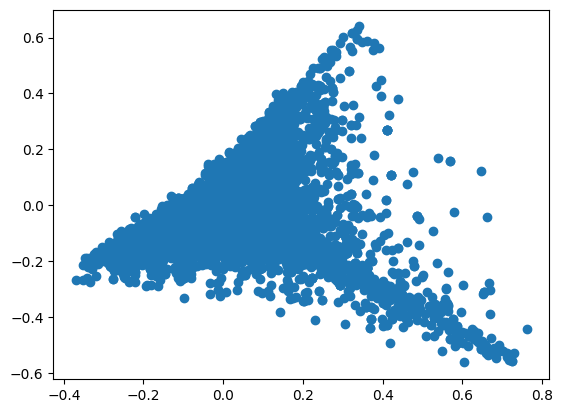

In [22]:
plt.scatter(pca_model[:,0], pca_model[:,1])
plt.show()

In [27]:
clustering = DBSCAN(eps=0.5, min_samples=3).fit(pca_model)
unique, counts = np.unique(clustering.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 15405]]
